## Вааааааа, новый блокнотик
Короче, закинул новый алгоритм. В коде снизу обучение на готовой модели. Взял ее отсюда: https://towardsdatascience.com/image-similarity-with-deep-learning-c17d83068f59
Должен был седня (01.11 в среду) показывать АН, но он на конференции был 🙃
Коротко говоря, модель натренирована преобразовать картинку в вектор, с которым можно дальше взаимодействовать с помощью мат. функций (к примеру, сравнить два вектора на схожесть). Вроде как этот алгоритм используется в поисках по изображению, там даже была ссылка на какой то фреймворк для таких целей

In [21]:
import tensorflow as tf
import tensorflow_hub as hub

model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

IMAGE_SHAPE = (224, 224)

layer = hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
model = tf.keras.Sequential([layer])


In [22]:
import numpy as np
import cv2
from PIL import Image
import sys

Вот здесь в функции производятся все необходимые действия для подготовки изображения к модели. Первые три строчки отвечают за подготовку, дальше проход через модель и возвращение вектора. Во время подготовки изображение: ресайзится, конвертируется в цветовую репрезентацию каждого пикселя и эта самая цветовая репрезентация "normalaising between 0 and 1"(хз, как перевести на русский, короче код цвета делится на 255, чтобы репрезентация цвета была между 0 и 1) 

In [23]:
def extract(file):
  file = Image.open(file).convert('L').resize(IMAGE_SHAPE)

  file = np.stack((file,)*3, axis=-1)

  file = np.array(file)/255.0

  embedding = model.predict(file[np.newaxis, ...])
  #print(embedding)
  vgg16_feature_np = np.array(embedding)
  flattended_feature = vgg16_feature_np.flatten()

  #print(len(flattended_feature))
  #print(flattended_feature)
  #print('-----------')
  return flattended_feature

Вот ета функция нужна для сравнения векторов. Можно брать разные метрики, но на скриншотах, что я тестил, метрика cosine (чувствую себя французом, пока пишк это) работает прекрасно

In [25]:
from scipy.spatial import distance

In [26]:
metric = 'cosine'

Тут сделал новую функцию. Частично повторяет прошлую, НО делит изображение на 4 части и возвращает вектор для каждой из них (думаю надо будет сделать деление на 6 частей, потом объясню, в час ночи уже лень (кста, я где то пиздил код со стаковерфлоу, где то давал простенькие запросы чат гпт для быстроты, так что комменты местами ебаные)).
Кста, мб потом засуну все в списки, чтоб код более красивенько выглядел, но не суть

In [30]:
def extract_quads(file):
    file = Image.open(file)
    # Get the dimensions of the image
    width, height = file.size

    # Calculate the dimensions of each quadrant
    quadrant_width = width // 2
    quadrant_height = height // 2
    #display(file)

    
    quadrant1 = file.crop((0, 0, quadrant_width, quadrant_height)).convert('L').resize(IMAGE_SHAPE)
    quadrant2 = file.crop((quadrant_width, 0, width, quadrant_height)).convert('L').resize(IMAGE_SHAPE)
    quadrant3 = file.crop((0, quadrant_height, quadrant_width, height)).convert('L').resize(IMAGE_SHAPE)
    quadrant4 = file.crop((quadrant_width, quadrant_height, width, height)).convert('L').resize(IMAGE_SHAPE)
    
    # quadrant1.save("quadrant1.png")
    # quadrant2.save("quadrant2.png")
    # quadrant3.save("quadrant3.png")
    # quadrant4.save("quadrant4.png")

    quadrant1 = np.stack((quadrant1,)*3, axis=-1)
    quadrant1 = np.array(quadrant1)/255.0

    quadrant2 = np.stack((quadrant2,)*3, axis=-1)
    quadrant2 = np.array(quadrant2)/255.0

    quadrant3 = np.stack((quadrant3,)*3, axis=-1)
    quadrant3 = np.array(quadrant3)/255.0

    quadrant4 = np.stack((quadrant4,)*3, axis=-1)
    quadrant4 = np.array(quadrant4)/255.0


    embedding = model.predict(quadrant1[np.newaxis, ...])
    vgg16_feature_np = np.array(embedding)
    quadrant1 = vgg16_feature_np.flatten()

    embedding = model.predict(quadrant2[np.newaxis, ...])
    vgg16_feature_np = np.array(embedding)
    quadrant2 = vgg16_feature_np.flatten()

    embedding = model.predict(quadrant3[np.newaxis, ...])
    vgg16_feature_np = np.array(embedding)
    quadrant3 = vgg16_feature_np.flatten()

    embedding = model.predict(quadrant4[np.newaxis, ...])
    vgg16_feature_np = np.array(embedding)
    quadrant4 = vgg16_feature_np.flatten()
    #print(quadrant4,quadrant1, quadrant2)
    return quadrant1, quadrant2, quadrant3, quadrant4

Дальше я проверяю на двух скриншотах действие программы (сделал в юнити небольшую симуляцию, там дрон + ландшафт взял с бесплатных ассетов с работы. Туда можно прикрутить скрипты из питона, правда это немного танцы с бубнами, но Марьенков просил. Если ты параллельно попробуешь запустить дрон на том софте, что ты скидывал из видео, будет волшебно, я тя расцелую. В нем будет легче закинуть питоновские скрипты на дрона)

In [31]:
screen1_quads = extract_quads("screen.png")
screen2_quads = extract_quads ("screen2.png")

1/1 [==============================] - 0s 61ms/step


Проверяю, какие изображения больше всего похожи через метрику из сайпая. Чем еньше значение, которое он возвращает, тем более пикчи схожи
Работало для нескольких скриншотов из юнити, но надо будет попробовать пофтокать ирл что нить и потестить

In [32]:
index=[0,0]
smallest_dist=1
for index1, image1 in enumerate(screen1_quads):
    for index2, image2 in enumerate(screen2_quads):
        dc = distance.cdist([image1], [image2], metric)[0]
        print(dc)
        if dc<smallest_dist:
            smallest_dist=dc
            index = [index1,index2]
print(index, smallest_dist)

[0.69149756]
[0.40586503]
[0.42902604]
[0.48904527]
[0.45265541]
[0.4717016]
[0.45851143]
[0.45836457]
[0.31644954]
[0.57295499]
[0.53145055]
[0.5643158]
[0.30926218]
[0.63399155]
[0.60187071]
[0.66431868]
[3, 0] [0.30926218]


Сделал подсветку тех частей изображения, что наиболее схожи. Опять же, можно чуть красивее код написать, но на данный момент сойдет

In [33]:
from PIL import ImageColor, ImageDraw, ImageEnhance

def highlight_area(img, region, factor, outline_color=None, outline_width=1):
    """ Highlight specified rectangular region of image by `factor` with an
        optional colored  boarder drawn around its edges and return the result.
    """
    img = img.copy()  # Avoid changing original image.
    img_crop = img.crop(region)

    brightner = ImageEnhance.Brightness(img_crop)
    img_crop = brightner.enhance(factor)

    img.paste(img_crop, region)

    # Optionally draw a colored outline around the edge of the rectangular region.
    if outline_color:
        draw = ImageDraw.Draw(img)  # Create a drawing context.
        left, upper, right, lower = region  # Get bounds.
        coords = [(left, upper), (right, upper), (right, lower), (left, lower),
                  (left, upper)]
        draw.line(coords, fill=outline_color, width=outline_width)

    return img

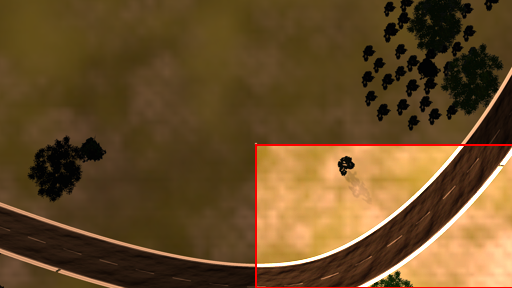

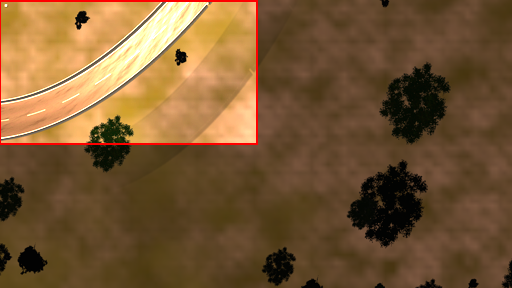

In [41]:
img = Image.open('screen.png')
img.thumbnail([512,512])

img2 = Image.open('screen2.png')
img2.thumbnail([512,512])

red = ImageColor.getrgb('red')

width, height = img.size

half_width = width // 2
half_height = height // 2
if index[0]==0:
    region = 0, 0, half_width, half_height
elif index[0]==1:
    region = half_width, 0, width, half_height
elif index[0]==2:
    region = 0, half_height, half_width, height
elif index[0]==3:
    region = half_width, half_height, width, height
img = highlight_area(img, region, 2.5, outline_color=red, outline_width=2)


if index[1]==0:
    region = 0, 0, half_width, half_height
elif index[1]==1:
    region = half_width, 0, width, half_height
elif index[1]==2:
    region = 0, half_height, half_width, height
elif index[1]==3:
    region = half_width, half_height, width, height
img2 = highlight_area(img2, region, 2.5, outline_color=red, outline_width=2)

display(img)  # Display the result.
display(img2)


Вооооооот. В общей сложности приколдесно, но нужно развить. если делить картинку на 6 частей, то в целом дрон примерно правильно будет лететь, особенно на маленьких расстояниях, но как то надо на больших дистанциях брать и сравнивать картинку, где он стоит с картинкой, где он должен стоять и чуть чуть корректировать полет, если надо